### This notebook merges the rgby microscope image into numpy array so that I/O of images isn't a bottleneck

In [1]:
import sys
sys.path.append("../..")
import numpy as np
import cv2
import os
import glob
from pathlib import Path

from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

from src.image import plot_rgby
from src.data import open_numpy

In [2]:
CHANNEL_COLORS = ['red', 'green', 'blue', 'yellow']

def read_channels(root_dir, img_id, img_extension="tif"):
    channels = []
    for color in CHANNEL_COLORS:
        image_path = root_dir / f"{img_id}_{color}.{img_extension}"
        channel = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
        channels.append(channel)
    channels = np.array(channels)
    assert channels.max() <= 255
    return channels.astype(np.uint8).transpose(1, 2, 0)


def get_image_ids(root_dir, img_extension="tif"):
    image_file_paths = root_dir.glob(f"*.{img_extension}")
    img_ids = []
    for fp in image_file_paths:
        d, f = os.path.split(fp)
        name, ext = os.path.splitext(f)
        fid, color = name.split('_')
        imgids.append(fid)
    img_ids = list(set(img_ids))
    return img_ids

KAGGLE_IMAGE_EXTENSION = "tif"
HPAV18_IMAGE_EXTENSION = "jpg"

def get_image_ids_HPAv18(root_dir):
    image_file_paths = root_dir.glob(f"*.{HPAV18_IMAGE_EXTENSION}")
    img_ids = []
    for fp in image_file_paths:
        img_ids.append("_".join(fp.stem.split("_")[:-1]))
    img_ids = list(set(img_ids))
    return img_ids

def get_image_ids(root_dir):
    image_file_paths = root_dir.glob(f"*.{KAGGLE_IMAGE_EXTENSION}")
    img_ids = []
    for fp in image_file_paths:
        img_ids.append(fp.stem.split("_")[0])
    img_ids = list(set(img_ids))
    return img_ids

def make_image_path(root_dir, img_id):
    path = root_dir / f"{img_id}.npy"
    return path

#### First we get the paths where the data is

In [3]:
root_dir = Path("/media/hd/Kaggle/human-protein-image-classification/data/trainHPAv18")
save_dir = Path("../../data/train_combined_HPAv18")
save_dir.mkdir(parents=True, exist_ok=True)

#### Now get the IDs of the images

In [4]:
img_ids = get_image_ids_HPAv18(root_dir)

#### Now make image path

In [5]:
img_id = img_ids[0]

In [6]:
img_id

'27208_548_H11_2'

In [7]:
make_image_path(save_dir, img_id)

PosixPath('../../data/train_combined_HPAv18/27208_548_H11_2.npy')

#### Now read the image

In [8]:
img = read_channels(root_dir, img_id, img_extension="jpg")

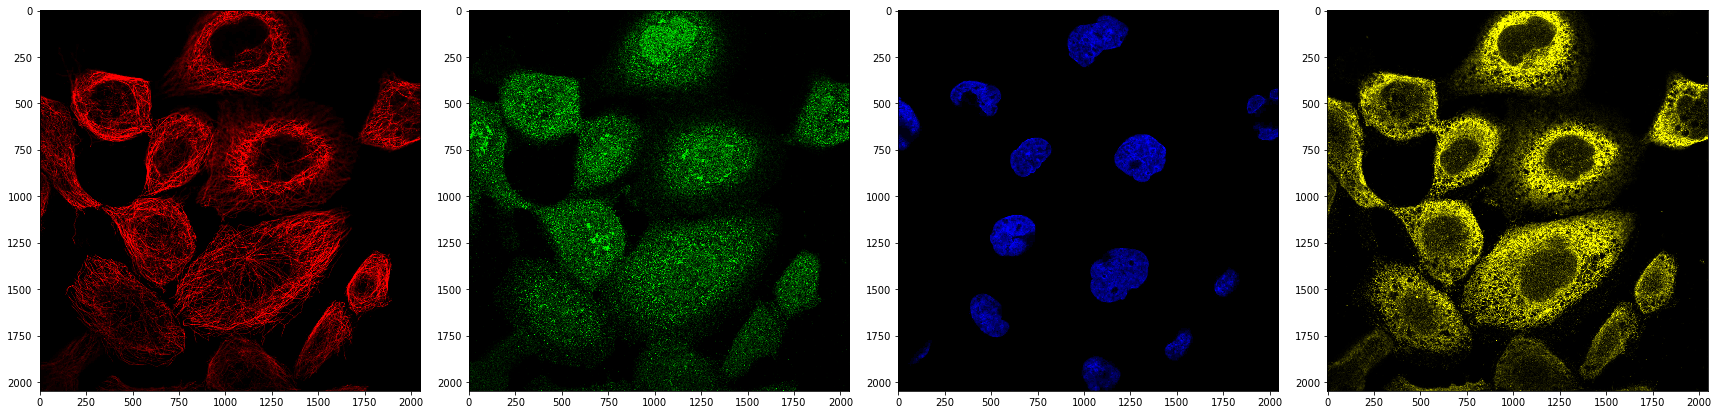

In [9]:
plot_rgby(img)

#### Use multiprocessing to save images

In [16]:
from multiprocessing import Pool
from miniutils.progress_bar import parallel_progbar, progbar

In [25]:
SIZE = (1024, 1024)
n_samples = len(img_ids)
iterable = zip([root_dir] * n_samples,
                [save_dir] * n_samples,
                img_ids,
                [HPAV18_IMAGE_EXTENSION] * n_samples,
                [SIZE] * n_samples)

In [26]:
def mapper(data):
    root_dir, save_dir, img_id, img_extension, size = data
    img_path = make_image_path(save_dir, img_id)
    channels = cv2.resize(read_channels(root_dir, img_id, img_extension), size)
    np.save(img_path, channels, allow_pickle=True)

In [ ]:
parallel_progbar(mapper, iterable)